In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

ip_map = {
    "45.77.229.242": "GB-London",
    "62.154.179.86": "DE-Berlin",
    "194.156.155.241": "ES-Madrid",
    "194.230.35.117": "CH-Zurich",
    # "193.46.104.17": "AT-Vienna", #should be .17 but error
    "193.46.104.12": "AT-Vienna",
    "185.32.189.249": "PT-Lisbon",
    "213.135.49.134": "PL-Warsaw",
    "51.159.68.135": "FR-Paris",
    "185.78.84.3": "TR-Istanbul",
    "185.157.208.248": "GR-Athens"
}

In [3]:
import geopandas as gpd

cities = {
    "GB-London": (-0.0695, 51.5185),
    "DE-Berlin": (13.4205, 52.5495),
    "ES-Madrid": (-3.6215, 40.4405),
    "CH-Zurich": (8.5605, 47.4185),
    "AT-Vienna": (16.4075, 48.2715),
    "PT-Lisbon": (-9.1215, 38.7915),
    "PL-Warsaw": (20.9375, 52.2515),
    "FR-Paris": (2.4075, 48.7905),
    "TR-Istanbul": (28.8305, 40.9915),
    "GR-Athens": (23.7705, 38.0695)
}

df = pd.DataFrame([
    {"city": name, "lon": coord[0], "lat": coord[1]}
    for name, coord in cities.items()
])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"
)

gdf = gdf.to_crs("EPSG:3857")

dist_rows = []
for src_city, dst_city in product(gdf['city'], repeat=2):
    src_geom = gdf[gdf['city'] == src_city].geometry.values[0]
    dst_geom = gdf[gdf['city'] == dst_city].geometry.values[0]
    
    dist_km = src_geom.distance(dst_geom) / 1000
    
    dist_rows.append({
        "src": src_city,
        "dst": dst_city,
        "distance_km": dist_km
    })
dist_df = pd.DataFrame(dist_rows)

In [4]:
trace_df = pd.read_csv("data/full/traceroute.csv")

trace_df['src'] = trace_df['src_addr'].map(ip_map)
trace_df['dst'] = trace_df['dst_addr'].map(ip_map)

trace_df['timestamp'] = pd.to_datetime(trace_df['timestamp'], unit='s')
trace_df = trace_df.sort_values('msm_id')

# http_df['pair'] = http_df['src'] + " - " + http_df['dst']

print(trace_df)

           msm_id         src_addr       dst_addr  hop  sent  received    min  \
329409  136909065      185.78.84.3  51.159.68.135    6     3         0  0.000   
329408  136909065      185.78.84.3  51.159.68.135    5     3         0  0.000   
329407  136909065      185.78.84.3  51.159.68.135    4     3         3  0.480   
329406  136909065      185.78.84.3  51.159.68.135    3     3         0  0.000   
329405  136909065      185.78.84.3  51.159.68.135    2     3         0  0.000   
...           ...              ...            ...  ...   ...       ...    ...   
3       136909083   194.230.35.117  62.154.179.86    4     3         3  1.501   
2       136909083   194.230.35.117  62.154.179.86    3     3         3  0.909   
1       136909083   194.230.35.117  62.154.179.86    2     3         3  0.814   
0       136909083   194.230.35.117  62.154.179.86    1     3         3  1.150   
21      136909083  194.156.155.241  62.154.179.86    3     3         0  0.000   

             avg    max    

In [5]:
final_hops = (
    trace_df.sort_values('hop')
            .groupby(['src_addr', 'dst_addr', 'timestamp'])
            .tail(1)
)
print(final_hops)

           msm_id        src_addr         dst_addr  hop  sent  received  \
61947   136909080  185.32.189.249  194.156.155.241    4     3         3   
49377   136909080  185.32.189.249  194.156.155.241    4     3         3   
88292   136909080  185.32.189.249  194.156.155.241    4     3         3   
88234   136909080  185.32.189.249  194.156.155.241    4     3         3   
88176   136909080  185.32.189.249  194.156.155.241    4     3         3   
...           ...             ...              ...  ...   ...       ...   
48      136909083     185.78.84.3    62.154.179.86  255     3         0   
329311  136909065     185.78.84.3    51.159.68.135  255     3         0   
329345  136909065     185.78.84.3    51.159.68.135  255     3         0   
329277  136909065     185.78.84.3    51.159.68.135  255     3         0   
237851  136909067     185.78.84.3    45.77.229.242  255     3         0   

           min        avg      max             from  timed_out  \
61947    9.058   9.089334    9.14

In [6]:
trace_errors_df = final_hops[final_hops['destination_ip_responded'] == False]
trace_good_df   = final_hops[final_hops['destination_ip_responded'] == True]

trace_good_swapped = trace_good_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
trace_good_symmetric = pd.concat([trace_good_df, trace_good_swapped], ignore_index=True)

trace_errors_swapped = trace_errors_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
trace_errors_symmetric = pd.concat([trace_errors_df, trace_errors_swapped], ignore_index=True)

agg_trace_good = trace_good_symmetric.groupby(['src', 'dst'])['avg'].mean().reset_index()
agg_trace_errors = trace_errors_symmetric.groupby(['src', 'dst'])['timed_out'].count().reset_index()

all_names = sorted([x for x in ip_map.values()])
full_pairs = pd.DataFrame(list(product(all_names, all_names)), columns=['src', 'dst'])
full_pairs = full_pairs.merge(dist_df, on=['src', 'dst'], how='left')

merged_good = full_pairs.merge(agg_trace_good, on=['src','dst'], how='left')
merged_good['ping_per_km'] = merged_good['avg'] / merged_good['distance_km'] * 1000
merged_good = merged_good.fillna(0).pivot(index='src', columns='dst', values='ping_per_km')

trace_good_heatmap_data = pd.merge(full_pairs, agg_trace_good, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='avg')
trace_errors_heatmap_data = pd.merge(full_pairs, agg_trace_errors, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='timed_out')

In [7]:
print(agg_trace_good[(agg_trace_good['src'] == "TR-Istanbul") & (agg_trace_good['avg'] > 0.0)])

            src        dst        avg
57  TR-Istanbul  GR-Athens  52.267748


Text(70.72222222222221, 0.5, 'Source Address')

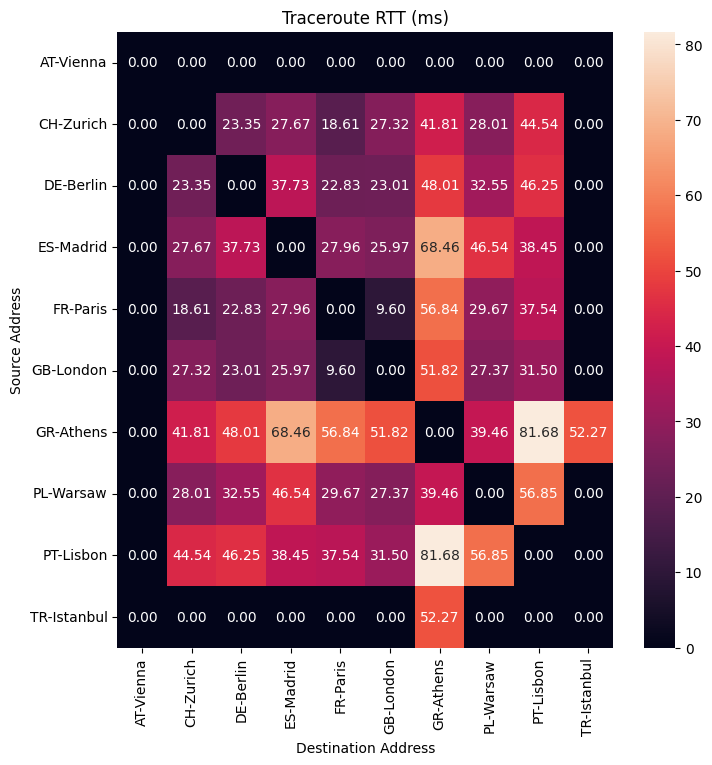

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(trace_good_heatmap_data, annot=True, fmt="0.2f", cmap="rocket")
plt.title("Traceroute RTT (ms)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

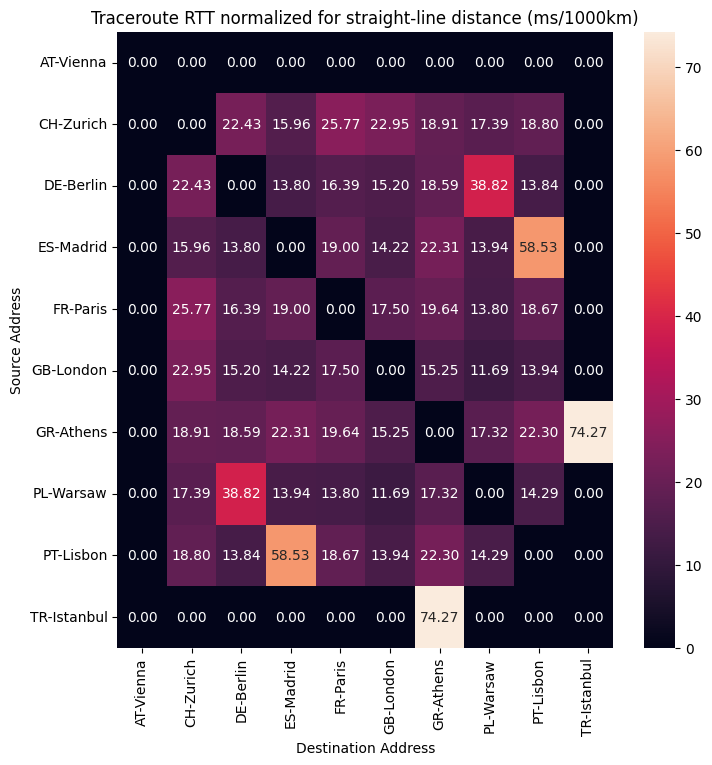

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(merged_good, annot=True, fmt="0.2f", cmap="rocket")
plt.title("Traceroute RTT normalized for straight-line distance (ms/1000km)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

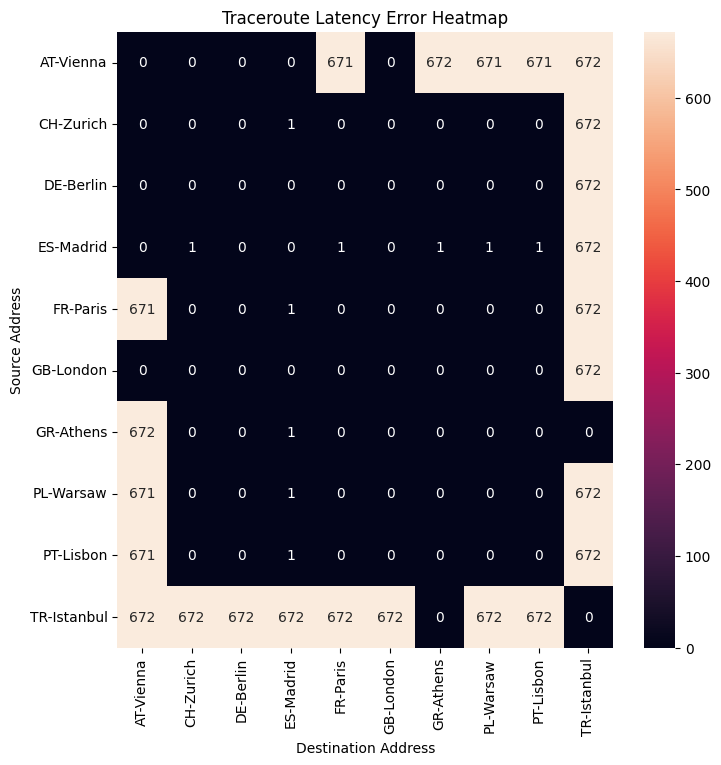

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(trace_errors_heatmap_data, fmt="0.0f", annot=True, cmap="rocket")
plt.title("Traceroute Latency Error Heatmap")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")